|<div style="width:330px"><img src="https://www.ufz.de/static/custom/weblayout/DefaultInternetLayout/img/logos/ufz_transparent_de_blue.png" width="300"/></div>|<div style="width:330px"><img src="https://discourse.opengeosys.org/uploads/default/original/1X/a288c27cc8f73e6830ad98b8729637a260ce3490.png" width="300"/></div>|<div style="width:330px"><img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="300"/></div>|
|---|---|--:|

In this benchmark problem we describe the influence of a heat flux on a two-phase system (aqueous phase gas phase), also commonly known as the heat pipe effect. The heat pipe effect describes heat transport in a porous medium caused by convection due to capillary forces. Detailed description of the heat-pipe prblem can be found in (Helmig et al., 1997).

This benchmark case considers the heat pipe effect for a two-phase system in a horizontal, one-dimensional column. As illustrated in the figure below, a constant heat flux $q$ is applied at one end of the column, which is sufficient to heat the water at this end of the column above boiling temperature. As the water vaporizes, the vapour moves towards the other end of the column, condensing to water again as it moves through cooler regions and, hence, giving up the latent heat of vaporization. The resulting non-linear water saturation profile along the horizontal column causes a capillary pressure gradient to arise, leading to a flux of the liquid phase pointing back towards the heat source: the mass of the vapour moving away from the heat source is equal to the mass of the condensate moving back towards the heat source.

![heatpipe_schematic.png](figures/heatpipe_schematic.png)

When a heat pipe evolves from a single-phase liquid region as a consequence of constant heat injection, the vapour that is created at the heat source, displaces the water first. As a result, the latent heat of evaporation is given up by the vapour at the condensation front, and a mass flux is formed by the condensate pointing away from the heat source towards the completely cooled end of the column (here liquid exists in a single-phase region). The capillary forces which arise due to the non-linear saturation profile along the column are strong enough to transport the entire condensate back to the heat source, as long as the heat source is strong enough to ensure constant vaporization and liquid saturation reduction at the heat source. Like this, a closed loop of mass cycle is created within the heat pipe, and the heat pipe reaches its maximum length when all the water is evaporized at the heat source and the evaporation front is far enough from the heat source so that the temperature is just enough for the vaporization. At this point the heat pipe will not propagate further and remains stationary.

While heat conduction is essential in the single-phase regions in front and behind the heat pipe for the heat transfer, the temperature gradient between the two ends of the heat pipe is relatively small, and therefore, within the heat pipe itself, heat conduction has no primary importance compared to convection.

This benchmark case assumes that the gas phase contains an additional component - air. The presence of air in the system results in the following considerations that are taken into account:

* While air does not condensate at the considered temperatures, its diffusion in the gas phase must be taken into account.
* The presence of non-condensable gas obstruct the convective transport of the latent heat of evaporation in the gas phase.
* As the additional gas component fills the pore space, it reduces the available volume for the liquid phase and consequently results in a lower relative permeability for the liquid phase.

For verification purposes, the numerical solution of this benchmark problem is compared to a semi-analytical solution. The semi-analytical solution is briefly introduced in the following sections.

# Analytical solution
The analytical solution of the heat pipe problem solves a coupled system of first order differential equations for pressure, temperature, saturation and mole fraction derived by (Udell and Fitch, 1985). The here presented solution is slightly modified by (Helmig et al., 1997), as not all original assumptions proposed by (Udell and Fitch, 1985) are satisfied in this benchmark, thus some generalization are applied and will be mentioned alongside the original considerations:

* The porous medium is homogeneous and incompressible: $\phi(z,p)=const.$ and $k=const.$
* Interfacial tension and viscosities of the gas phase and the liquid phase are constant: $\sigma=const.$ , $\mu_{\alpha}=const.$ **Attention:** we do not consider the viscosity of the gas phase constant due to the presence of air in the system. Instead, the viscosity of the gas phase is calculated as the mole fraction-weighted average of air and vapour viscosity in the gas phase:

\begin{align}
    \mu_g=x_g^a\mu_g^a+x_g^w\mu_g^w
\end{align}

* Density changes of the gas and liquid phase due to pressure, temperature and composition variation is neglected: $\rho_{\alpha}=const.$ **Attention:** we take into account the infuence of air presence in the gas phase density. The density of the gas mixture is calculated as the sum of the partial density of the two component. Including the ideal gas law, the gas phase density is:

\begin{align}
    \rho_g=\frac{p_g}{(RT)(x_g^aM^a+x_g^wM^w)}
\end{align}

* The single-phase regions at the boundary of the heat pipe are not considered in the solution.

### Input parameters
The following material parameters and heat flow value are considered as input parameters.

In [4]:
import math

import numpy as np

q = -100.0  # heat injection [W/m²]

K = 1e-12  # permeability [m²]
phi = 0.4  # porosity [-]

p_ref = 101325  # reference pressure [Pa]
T_ref = 373.15  # reference temperature [K]

lambda_G = 0.2  # thermal conductivity of gas phase [W/mK]
lambda_L = 0.5  # thermal conductivity of liquid phase [w/mK]
lambda_S = 1.0  # thermal conductivity of solid matrix [w/mK]
dh_evap = 2258000  # latent heat of evaporation [J/kg]

D_pm = 2.6e-6  # binary diffusion coefficient [m²/s]
rho_L = 1000.0  # density of liquid phase [kg/m³]
MW = 0.018016  # molecular weight of water component [kg/mol]
MC = 0.028949  # molecular weight of air component [kg/mol]
R = 8.3144621  # universal gas constant

mu_L = 2.938e-4  # dynamic viscosity of liquid phase [Pa.s]
muA_G = 2.194e-5  # dynamic viscosity of air component in gas phase [Pa.s]
muW_G = 1.227e-5  # dynamic viscosity of water component in gas phase [Pa.s]

s_LRes = 0.0  # residual saturation of liquid phase [-]
s_GRes = 0.0  # residual saturation of gas phase [-]

k_rG_min = 1e-5  # used for normalization of BC model
k_rL_min = 1e-5  # used for normalization of BC model
p_thr_BC = 5.0e3  # entry pressure for Brooks-Corey model [Pa]
exp_BC = 3.0  # Corey exponent for Brooks-Corey model [-]

### Constitutive relations

The system of balance equations from the previous chapter has to be closed by a variety of constitutive relations, which in turn specify the necessary material properties and express the thermodynamic equilibrium between the constituents of liquid and gas phases. We apply the same relations in the analytical solution and in the numerical model as well.

Due to the existence of multiple phases within the pore space, the movement of a ﬂuid phase is obstructed by the presence of the other phase. In multiphase ﬂow applications, this effect is usually realised by introducing relative permeabilities as functions of saturation which calculate the effective permeability of each phase as described in the extended Darcy law. Additionally if the present phases are immiscible, one also needs to consider the arising capillary effects by introducing capillary pressure accounting for the difference of phase pressures.

The Brooks-Corey formulation accounts for residual saturations of both ﬂuid phases and links effective saturation to capillary pressure. Additionally, it also models the relative permeability of both phases as a function of effective liquid saturation.

In [5]:
def capillary_pressure(sL_eff):
    return p_thr_BC * (sL_eff ** (-1.0 / exp_BC))


def capillary_pressure_derivative(sL_eff):
    return -p_thr_BC / exp_BC * (sL_eff ** (-(exp_BC + 1.0) / exp_BC))


def saturation_effective(p_c):
    return (p_c / p_thr_BC) ** (-exp_BC)


def relative_permeability_gas(sL_eff):
    return max(
        k_rG_min, ((1.0 - sL_eff) ** 2) * (1 - (sL_eff ** ((2.0 + exp_BC) / exp_BC)))
    )


def relative_permeability_liquid(sL_eff):
    return max(k_rL_min, sL_eff ** ((2.0 + 3 * exp_BC) / exp_BC))

Determining the composition of the gas phase, we assume that the sum of all constituents’ partial pressures accounts for the entire gas phase pressure (Dalton’s law). The partial pressure of water vapour is derived from the true vapour pressure that accounts for the impact of capillary effects as well: due to wettability and capillarity, the interfaces prevailing in porous media are not flat, but rather curving. Above curved interfaces, the vapour pressure may change depending on the direction of curvature. The Kelvin-Laplace equation accounts for this and expresses the true vapour pressure as a function of capillary pressure and the saturation vapour pressure of pure water.

The saturation vapour pressure is determined by the approximate Clausius-Clapeyron equation.

In [6]:
def vapour_pressure(p_sat, p_G, p_c, xA_G, T):
    return p_sat * math.exp(-(p_c - xA_G * p_G) * MW / rho_L / R / T)


def saturation_vapour_pressure(T):
    return p_ref * math.exp((1.0 / T_ref - 1.0 / T) * dh_evap * MW / R)


def partial_pressure_vapour(p_G, p_c, xA_G, T):
    p_sat = saturation_vapour_pressure(T)
    return vapour_pressure(p_sat, p_G, p_c, xA_G, T)

The gas phase density can be determined using an appropriate equation of state for binary mixtures, such as the Peng-Robinson equation of state. For simplicity, we use the thermal equation of state of ideal gases in this work, which gives sufﬁcient results at high temperatures and low pressures.

Dynamic viscosity of composite phases is obtained from the simple mixing rule.

In [7]:
def molar_mass_gas_phase(xA_G):
    return xA_G * MC + (1 - xA_G) * MW


def density_gas_phase(p_G, xA_G, T):
    M = molar_mass_gas_phase(xA_G)
    return p_G * M / (R * T)


def viscosity_gas_phase(xA_G):
    return xA_G * muA_G + (1.0 - xA_G) * muW_G


def kinematic_viscosity_gas_phase(p_G, xA_G, T):
    mu_G = viscosity_gas_phase(xA_G)
    rho_G = density_gas_phase(p_G, xA_G, T)
    return mu_G / rho_G

The macroscopic diffusion constant (diffusivity) is determined using a simple correction accounting for porosity and gas saturation on the microscopic diffusion constant ($D_{pm}^G$).

In [8]:
def diffusivity(sL_eff):
    return phi * (1.0 - sL_eff) * D_pm

When heat conduction occurs over multiple phases, a mixing rule can describe averaged heat conduction if local thermal equilibrium is assumed. In this case, we apply a very simple model (upper Wiener bound, Wiener 1912) to ﬁnd an effective heat conductivity by averaging individual phase conductivities by volume fraction.

In [9]:
def thermal_conductivity(sL_eff):
    sL = sL_eff * (1.0 - s_GRes - s_LRes) + s_LRes
    phi_G = (1.0 - sL) * phi
    phi_L = sL * phi
    phi_S = 1.0 - phi
    return lambda_G * phi_G + lambda_L * phi_L + lambda_S * phi_S

### Governing equations
The solution for the 4 primary variables (liquid phase saturation, gas phase pressure, mole fraction of air in the gas phase and temperature) is obtained from the numerical integration of a coupled system of first order differential equations.

\begin{align}
    \frac{\partial z}{\partial S_{L,eff}}=\frac{-\frac{dp_c}{dS_{L,eff}}}{\theta \omega 
    \frac{1}{k_{rG}}( \frac{1}{1-x_G^a} + \frac{\nu_L}{\nu_G} \frac{k_{rG}}{k_{rL}} )}
\end{align}

\begin{align}
    \frac{\partial p_G}{\partial S_{L,eff}}=\frac{\frac{dp_c}{dS_{L,eff}}}{1 +
    \frac{\nu_L}{\nu_G} \frac{k_{rG}}{k_{rL}} ({1-x_G^a})}
\end{align}

\begin{align}
    \frac{\partial x_G^a}{\partial S_{L,eff}}=\frac{-\frac{dp_c}{dS_{L,eff}} \frac{K}{\nu_G \rho_G D_{pm}}
    \frac{1}{1-x_G^a}}{\frac{1}{k_{rG}} ( \frac{1}{1-x_G^a} + \frac{\nu_L}{\nu_G}
    \frac{k_{rG}}{k_{rL}} )}
\end{align}

\begin{align}
    \frac{\partial T}{\partial S_{L,eff}}=\frac{\frac{dp_c}{dS_{L,eff}}
    \frac{1-\theta}{\theta} \frac{dh_{evap} K}{\nu_g D_{pm}}}{\frac{1}{k_{rG}}
    ( \frac{1}{1-x_G^a} + \frac{\nu_L}{\nu_G} \frac{k_{rG}}{k_{rL}} )}
\end{align}

The differentail equations given by (Udell and Fitch, 1985) that are shown above are derived on the basis of mass and energy balance. It should be noted that the equation system is integrated over the effective saturation instead of the spatial coordinate $z$. The above given equations are reached when:

* the effective saturation is coupled to the spatial coordinate through the introduction of capillary pressure

\begin{align}
    \frac{dz}{dS_{L,eff}}=\frac{dp_c/dS_{L,eff}}{\partial p_c / \partial z}
\end{align}
 
* and the following chain rule is applied to the primary variable derivatives, e.g.:

\begin{align}
    \frac{\partial p_G}{\partial S_{L,eff}}=\frac{\partial p_G}{\partial z}
    \frac{\partial z}{\partial S_{L,eff}}
\end{align}

The parameter $\eta$ in the energy balance equation represents the ratio of the heat flux caused by convection to the total heat flux $q$:

\begin{align}
    \eta = 1+\frac{\lambda \frac{\partial T}{\partial z}}{q}
\end{align}

With some algebraic transformation, $\eta$ can also be explicitly expressed by

\begin{align}
    \alpha = 1+ \frac{p_c - x_G^a p_G}{dh_{evap} \rho_L}
\end{align}

\begin{align}
    \delta = \frac{\rho_L dh_{evap}^2 K \alpha}{\lambda \nu_G T}
\end{align}

\begin{align}
    \xi = \frac{1}{k_{rG}} (1+ \frac{\rho_L R T}{p_G M^w} \frac{1}{1-x_G^a})+
    \frac{\nu_L}{\nu_G k_{rL}}
\end{align}

\begin{align}
    \zeta = \frac{K \rho_L R T}{\rho_G \nu_G D_{pm} M^w} \frac{x_G^a}{1-x_G^a}
    (\frac{p_G M^w}{\rho_L R T} + \frac{1}{1-x_G^a})
\end{align}

\begin{align}
    \eta = \frac{\delta}{\delta \xi \zeta}
\end{align}

Including the reformulated $\eta$ and grouping some of the parameters under $\gamma$ and $\omega$, the 4 governing equation can be calculated in the following form:

\begin{align}
    \gamma = \frac{1}{k_{rG}}
    ( \frac{1}{1-x_G^a} + \frac{\nu_L}{\nu_G} \frac{k_{rG}}{k_{rL}} )
\end{align}

\begin{align}
    \omega = \frac{q \nu_G}{dh_{evap} K}
\end{align}

\begin{align}
    \frac{\partial z}{\partial S_{L,eff}} = \frac{-\frac{dp_c}{dS_{L,eff}}}{\eta \omega
    \gamma}
\end{align}

\begin{align}
    \frac{\partial p_G}{\partial S_{L,eff}} = \frac{\frac{dp_c}{dS_{L,eff}}}{\gamma k_{rG}
    (1-x_G^a)}
\end{align}

\begin{align}
    \frac{\partial x_G^a}{\partial S_{L,eff}} = \frac{-\frac{dp_c}{dS_{L,eff}} \frac{K}{\nu_G \rho_G D_{pm}}
    \frac{1}{1-x_G^a}}{\gamma}
\end{align}

\begin{align}
    \frac{\partial T}{\partial S_{L,eff}} = \frac{\frac{dp_c}{dS_{L,eff}}
    \frac{1-\theta}{\theta} \frac{dh_{evap} K}{\nu_g D_{pm}}}{\gamma}
\end{align}

The full derivation of the analytical solution can be found in (Helmig et al., 1997).

In [11]:
# Parameter grouping
def alpha_(sL_eff, p_G, xA_G):
    p_c = capillary_pressure(sL_eff)
    return 1.0 + ((p_c - xA_G * p_G) / (dh_evap * rho_L))


def delta_(sL_eff, p_G, xA_G, T):
    alpha = alpha_(sL_eff, p_G, xA_G)
    nu_G = kinematic_viscosity_gas_phase(p_G, xA_G, T)
    th_cond = thermal_conductivity(sL_eff)
    return (rho_L * (dh_evap**2) * K * alpha) / (th_cond * nu_G * T)


def xi_(sL_eff, p_G, xA_G, T):
    k_rG = relative_permeability_gas(sL_eff)
    k_rL = relative_permeability_liquid(sL_eff)
    nu_G = kinematic_viscosity_gas_phase(p_G, xA_G, T)
    nu_L = mu_L / rho_L
    return ((1.0 + ((rho_L * R * T) / (p_G * MW * (1.0 - xA_G)))) / k_rG) + (
        nu_L / nu_G
    ) / k_rL


def zeta_(sL_eff, p_G, xA_G, T):
    D = diffusivity(sL_eff)
    mu_G = viscosity_gas_phase(xA_G)
    a = K * rho_L * R * T * xA_G
    b = mu_G * D * MW * (1.0 - xA_G)
    c = p_G * MW / (rho_L * R * T) + 1.0 / (1.0 - xA_G)
    return (a / b) * c


def eta_(sL_eff, p_G, xA_G, T):
    delta = delta_(sL_eff, p_G, xA_G, T)
    xi = xi_(sL_eff, p_G, xA_G, T)
    zeta = zeta_(sL_eff, p_G, xA_G, T)
    return delta / (delta + xi + zeta)


def gamma_(sL_eff, p_G, xA_G, T):
    k_rG = relative_permeability_gas(sL_eff)
    k_rL = relative_permeability_liquid(sL_eff)
    nu_G = kinematic_viscosity_gas_phase(p_G, xA_G, T)
    nu_L = mu_L / rho_L
    return 1.0 / k_rG * ((1.0 / (1.0 - xA_G)) + (nu_L / nu_G) * (k_rG / k_rL))


# Differential equations
# Spatial variable (1D) derivative


def dz_dsL_eff(sL_eff, p_G, xA_G, T):
    dpC_dsL_eff = capillary_pressure_derivative(sL_eff)
    eta = eta_(sL_eff, p_G, xA_G, T)
    gamma = gamma_(sL_eff, p_G, xA_G, T)
    nu_G = kinematic_viscosity_gas_phase(p_G, xA_G, T)
    omega = (q * nu_G) / (dh_evap * K)
    return -dpC_dsL_eff / (eta * omega * gamma)


# Gas-phase pressure derivative


def dp_G_dsL_eff(sL_eff, p_G, xA_G, T):
    dpC_dsL_eff = capillary_pressure_derivative(sL_eff)
    gamma = gamma_(sL_eff, p_G, xA_G, T)
    k_rG = relative_permeability_gas(sL_eff)
    return dpC_dsL_eff / (gamma * k_rG * (1.0 - xA_G))


# Mole fraction of air component in gas phase derivative


def dxA_G_dsL_eff(sL_eff, p_G, xA_G, T):
    dpC_dsL_eff = capillary_pressure_derivative(sL_eff)
    gamma = gamma_(sL_eff, p_G, xA_G, T)
    mu_G = viscosity_gas_phase(xA_G)
    D = diffusivity(sL_eff)
    return -dpC_dsL_eff * K / (mu_G * D) * xA_G / (1.0 - xA_G) / gamma


# Temperature derivative


def dT_dsL_eff(sL_eff, p_G, xA_G, T):
    dpC_dsL_eff = capillary_pressure_derivative(sL_eff)
    eta = eta_(sL_eff, p_G, xA_G, T)
    gamma = gamma_(sL_eff, p_G, xA_G, T)
    nu_G = kinematic_viscosity_gas_phase(p_G, xA_G, T)
    th_cond = thermal_conductivity(sL_eff)
    return dpC_dsL_eff * (1.0 - eta) / eta * dh_evap / (nu_G * th_cond) * K / gamma

### Numerical integration over effective liquid saturation
To obtain the analytical solution, the above introduced four coupled differential equation can now be integrated with the well-know Forward Euler method.

To get a unique solution, the following boundary and initial conditions are considered:

* On the left-hand side ($z = 0$) - the cool end: $S_L = 1$  , $p_G = p_{G,i}$  ,  $x_G^a = x_{G,i}^a$  and $T = T_i$.

* On the right-hand side - the hot end of the the heat pipe, a constant heat-flux is considered: $q = -100 W/m^2$.

* As initial conditions we chose: $S_L = 1$  , $p_G = 101325 Pa$  ,  $x_G^a = 0.25$ (computed according to Dalton's law using the true vapour pressure assuming $p_{c,i} = 5001 Pa$)  and $T = 365 K$.


In [12]:
# Define right-hand-sides of the coupled system of first order derivative equations
def dy_dsL_eff(_y, sL_eff, p_G, xA_G, T):
    dydsL = np.zeros(4)
    dydsL[0] = dz_dsL_eff(sL_eff, p_G, xA_G, T)
    dydsL[1] = dp_G_dsL_eff(sL_eff, p_G, xA_G, T)
    dydsL[2] = dxA_G_dsL_eff(sL_eff, p_G, xA_G, T)
    dydsL[3] = dT_dsL_eff(sL_eff, p_G, xA_G, T)
    return dydsL


# Numerical integration - Forward Euler method
# to estimate the integrals of the coupled equation system


def step_Euler(y, sL_eff, dsL_eff, p_G, xA_G, T):
    return y + dsL_eff * dy_dsL_eff(y, sL_eff, p_G, xA_G, T)


def full_Euler(dsL_eff, y0, sL_eff_low, sL_eff_high):
    max_steps = int(abs((sL_eff_low - sL_eff_high) / dsL_eff))
    sL_eff_list = np.linspace(sL_eff_low, sL_eff_high, max_steps + 1)
    M = np.zeros(
        (4, max_steps + 1)
    )  # Solution matrix containing the 4 primary variable
    M[:, 0] = y0
    for i in range(max_steps):
        p_G = M[1, i]
        xA_G = M[2, i]
        T = M[3, i]
        if (dz_dsL_eff(sL_eff_list[i], p_G, xA_G, T) * dsL_eff) < 1.0:
            M[:, i + 1] = step_Euler(M[:, i], sL_eff_list[i], dsL_eff, p_G, xA_G, T)
        else:
            M[:, i + 1] = np.nan
    return M, sL_eff_list


# initial condition
z_0 = 0
p_G0 = 101325
p_c0 = 5001
T_0 = 365
xA_G0 = 1 - partial_pressure_vapour(p_G0, p_c0, 0, T_0) / p_G0
y0 = np.array([z_0, p_G0, xA_G0, T_0])

# initial effective saturation
sL_eff_0 = saturation_effective(p_c0)

# integration boundaries and saturation step size
sL_eff_low = sL_eff_0
sL_eff_high = 10e-16
n_dsL_eff = 10**2
dsL_eff = (sL_eff_high - sL_eff_low) / n_dsL_eff

# execute analytical solution
M, sL_eff_list = full_Euler(dsL_eff, y0, sL_eff_low, sL_eff_high)

# Numerical solution

In the following section, the previously analitically solved heatpipe problem is solved using numerical methods (FEM in OpenGeoSys). The numerical solution takes the exact same input parameters, and considers the same - modified - assumptions that are mentioned in the analytical solution.

Additionally, it is necessary to introduce a discretized spacial domain for the numerical simulation. We chose a 1 dimensional domain with length of 1 m discretized into 200 equally spaced identical elements.

The numerical problem considers the same consitutive relationships and identical boundary and initial conditions. We use the TH2M model of OGS to solve the coupled partial differential equations describing the system behavior. Detailed description of the numerical model can be found in (Grunwald et al., 2022).

In [2]:
import os
from pathlib import Path

import ogstools as ot

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

prj_file = "heat_pipe_rough.prj"
model = ot.Project(input_file=prj_file, output_file=prj_file)
model.run_model(logfile=f"{out_dir}/out.txt", args=f"-o {out_dir}")

OGS finished with project file ../../Data/TH2M/TH2/heatpipe/heat_pipe_rough.prj.
Execution took 176.3947033882141 s


# Results comparison

To compare the results produced by the analytical solution and those by the numerical compution by OpenGeoSys, the four primary variables are plotted along the 1D domain ($z$): liquid phase saturation ($S_{L,eff}$), air molar fraction in the gas phase ($x_G^a$), temperature ($T$) and gas phase pressure ($p_G$).

In [13]:
# Import OGS simulation results
import pyvista as pv

pv.set_plot_theme("document")
pv.set_jupyter_backend("static")

pvd_file = f"{out_dir}/results_heatpipe_rough.pvd"
reader = pv.get_reader(pvd_file)
reader.set_active_time_value(1.0e7)  # set reader to simulation end-time
mesh = reader.read()[0]

# Define line along mesh and extract data along line for plotting
pt1 = (0, 0.0025, 0)
pt2 = (1, 0.0025, 0)
xaxis = pv.Line(pt1, pt2, resolution=2)
line_mesh = mesh.slice_along_line(xaxis)

x_num = line_mesh.points[:, 0]  # x coordinates of each point
S_num = line_mesh.point_data["saturation"]
xA_G_num = line_mesh.point_data["xnCG"]
p_G_num = line_mesh.point_data["gas_pressure"]
T_num = line_mesh.point_data["temperature"]

# Resampling dataset via linear interpolation for error calculation
S_num_interp = np.interp(M[0, :], x_num, S_num)
xA_G_num_interp = np.interp(M[0, :], x_num, xA_G_num)
p_G_num_interp = np.interp(M[0, :], x_num, p_G_num)
T_num_interp = np.interp(M[0, :], x_num, T_num)

As one can see from the figures below, the numerical results are in really good agreement with the analytical solution. To better understand and visualize the deviation, we also perform a quick error analysis by simply calculating the difference (absolute and relative error) between the analytical and the numerical solution.

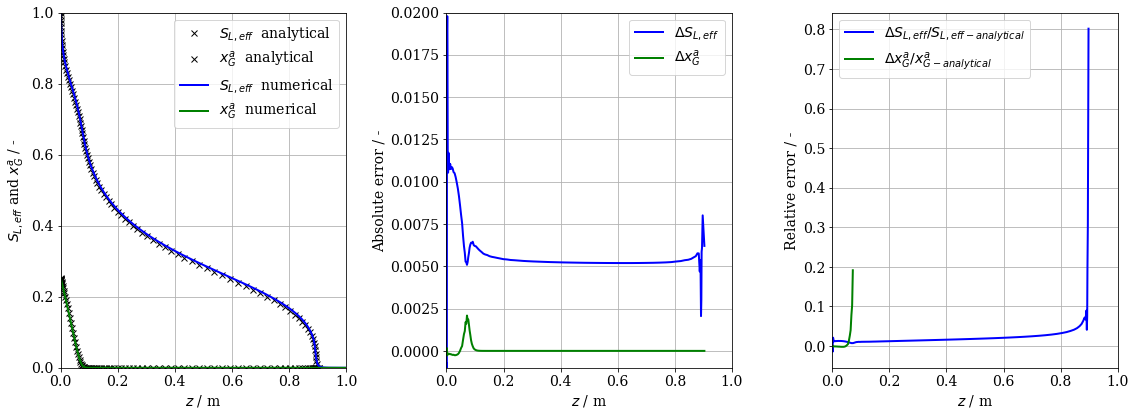

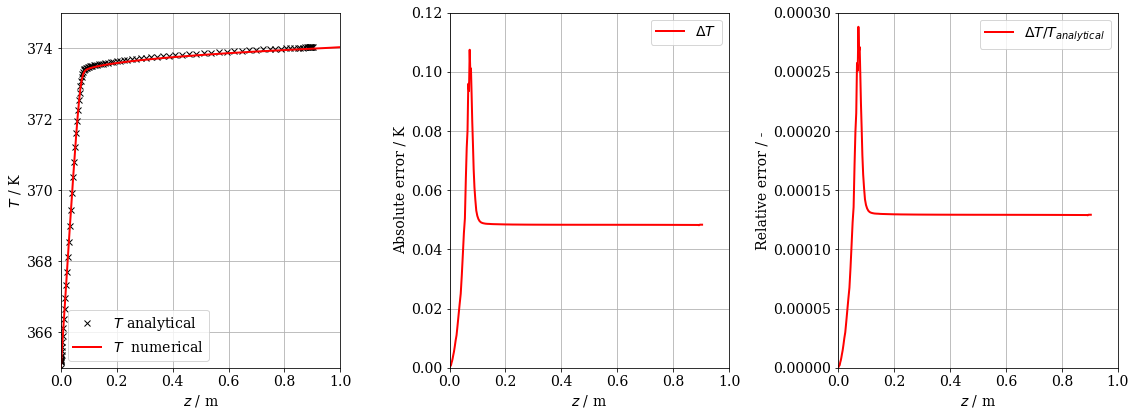

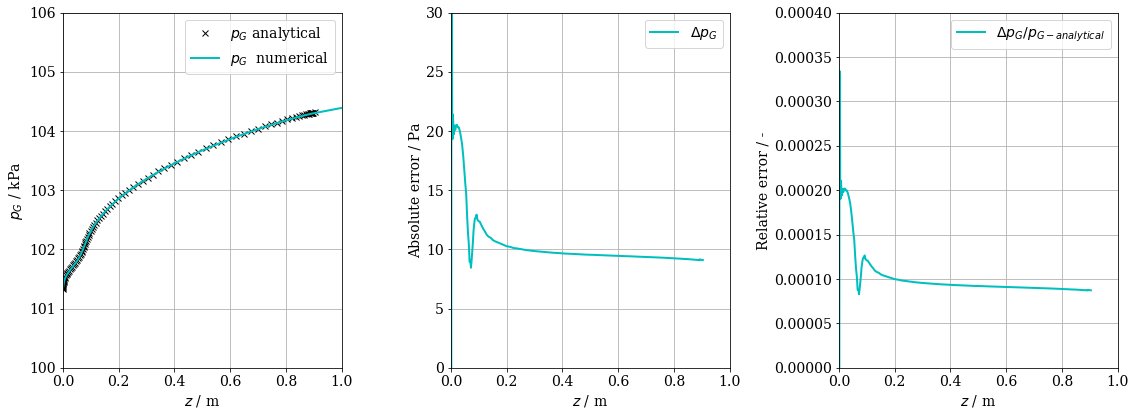

In [14]:
import matplotlib.pyplot as plt

plt.rcParams["lines.linewidth"] = 2.0
plt.rcParams["lines.color"] = "black"
plt.rcParams["legend.frameon"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["font.size"] = 14
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["figure.figsize"] = (16, 6)

fig1, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(M[0, :], sL_eff_list, "kx", label=r"$S_{L,eff}$  analytical")
ax1.plot(M[0, :], M[2, :], "kx", label=r"$x_G^a$  analytical")
ax1.plot(x_num, S_num, "b", label=r"$S_{L,eff}$  numerical")
ax1.plot(x_num, xA_G_num, "g", label=r"$x_G^a$  numerical")
ax1.set_xlabel(r"$z$ / m")
ax1.set_ylabel(r"$S_{L,eff}$ and $x_G^a$ / -")
ax1.legend()
ax1.grid(True)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

ax2.plot(M[0, :], S_num_interp - sL_eff_list, "b", label=r"$\Delta S_{L,eff}$")
ax2.plot(M[0, :], xA_G_num_interp - M[2, :], "g", label=r"$\Delta x_G^a$")
ax2.set_xlabel(r"$z$ / m")
ax2.set_ylabel(r"Absolute error / -")
ax2.legend()
ax2.grid(True)
ax2.set_xlim(0, 1)
ax2.set_ylim(-0.001, 0.02)

relError_S_w = np.zeros(len(M[0, :]))
relError_xA_G = np.zeros(len(M[0, :]))
for i in range(len(M[0, :])):
    if (sL_eff_list[i]) >= 0.001:
        relError_S_w[i] = (S_num_interp[i] - sL_eff_list[i]) / sL_eff_list[i]
    else:
        relError_S_w[i] = np.nan
    if (M[2, i]) >= 0.01:
        relError_xA_G[i] = (xA_G_num_interp[i] - M[2, i]) / M[2, i]
    else:
        relError_xA_G[i] = np.nan
ax3.plot(M[0, :], relError_S_w, "b", label=r"$\Delta S_{L,eff}/S_{L,eff-analytical}$")
ax3.plot(M[0, :], relError_xA_G, "g", label=r"$\Delta x_G^a/x_{G-analytical}^a$")
ax3.set_xlabel(r"$z$ / m")
ax3.set_ylabel(r"Relative error / -")
ax3.set_xlim(0, 1)
ax3.legend()
ax3.grid(True)
fig1.tight_layout()
plt.show()

fig2, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(M[0, :], M[3, :], "kx", label=r"$T$ analytical")
ax1.plot(x_num, T_num, "r", label=r"$T$  numerical")
ax1.set_xlabel(r"$z$ / m")
ax1.set_ylabel(r"$T$ / K")
ax1.legend()
ax1.grid(True)
ax1.set_xlim(0, 1)
ax1.set_ylim(365, 375)

ax2.plot(M[0, :], -T_num_interp + M[3, :], "r", label=r"$\Delta T$")
ax2.set_xlabel(r"$z$ / m")
ax2.set_ylabel(r"Absolute error / K")
ax2.legend()
ax2.grid(True)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 0.12)

ax3.plot(
    M[0, :],
    (-T_num_interp + M[3, :]) / M[3, :],
    "r",
    label=r"$\Delta T/T_{analytical}$",
)
ax3.set_xlabel(r"$z$ / m")
ax3.set_ylabel(r"Relative error / -")
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 0.0003)
ax3.legend()
ax3.grid(True)
fig2.tight_layout()
plt.show()

fig3, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(M[0, :], M[1, :] / 1000, "kx", label=r"$p_G$ analytical")
ax1.plot(x_num, p_G_num / 1000, "c", label=r"$p_G$  numerical")
ax1.set_xlabel(r"$z$ / m")
ax1.set_ylabel(r"$p_G$ / kPa")
ax1.legend()
ax1.grid(True)
ax1.set_xlim(0, 1)
ax1.set_ylim(100, 106)

ax2.plot(M[0, :], -p_G_num_interp + M[1, :], "c", label=r"$\Delta p_G$")
ax2.set_xlabel(r"$z$ / m")
ax2.set_ylabel(r"Absolute error / Pa")
ax2.legend()
ax2.grid(True)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 30)

ax3.plot(
    M[0, :],
    (-p_G_num_interp + M[1, :]) / M[1, :],
    "c",
    label=r"$\Delta p_G/p_{G-analytical}$",
)
ax3.set_xlabel(r"$z$ / m")
ax3.set_ylabel(r"Relative error / -")
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 0.0004)
ax3.legend()
ax3.grid(True)
fig3.tight_layout()
plt.show()

## References

[1] Helmig, R. et al. (1997). Multiphase ﬂow and transport processes in the subsurface: a contribution to the modeling of hydrosystems. Springer-Verlag.

[2] Udell, K. and Fitch, J. (1985) Heat and mass transfer in capillary porous media considering evaporation, condensation, and non-condensible gas effects. 23rd ASME/AIChE national heat transfer conference, Denver, pp. 103-110.

[3] Wiener, O. (1912). “Abhandl. math.-phys”. In: Kl. Königl. Sächsischen Gesell 32, p. 509.

[4] Grunwald, N. et al. (2022). Non-isothermal two-phase ﬂow in deformable porous media: Systematic open-source implementation and veriﬁcation procedure. Geomech. Geophys. Geo-energ. Geo-resour., 8, 107
https://link.springer.com/article/10.1007/s40948-022-00394-2